# **Import Library**

In [1]:
import cv2
from PIL import Image, ImageFile
import skimage
from skimage.transform import resize
from skimage.transform import rotate, warp

In [2]:
import keras
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

# **Upload Data dari Kaggle**

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmadzulzhafran","key":"5686cda5cf3ae2a4d173988f5d2bc804"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d bmadushanirodrigo/fracture-multi-region-x-ray-data

Dataset URL: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data
License(s): ODC Public Domain Dedication and Licence (PDDL)


In [6]:
!unzip -q fracture-multi-region-x-ray-data.zip -d bone-fracture-dataset

# **Data Pre-processing**

In [7]:
TRAIN_DIR = 'bone-fracture-dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'
VAL_DIR   = 'bone-fracture-dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val'
TEST_DIR  = 'bone-fracture-dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

## **Augmentasi & Generator**

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, horizontal_flip=True)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


In [9]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# **Modelling**

## **Model Arsitektur ResNet50**

In [10]:
tf.keras.backend.clear_session()

# Load ResNet50 model tanpa classifier (fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Menambahkan custom classifier
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Membuat model dengan ResNet50 sebagai base
model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00009),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 75,231,617 (286.99 MB)

 Trainable params: 51,643,905 (197.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## **Training Model**

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.5042 - loss: 0.8765

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


289/289 ━━━━━━━━━━━━━━━━━━━━ 153s 476ms/step - accuracy: 0.5043 - loss: 0.8761 - val_accuracy: 0.4186 - val_loss: 0.6775
Epoch 2/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 122s 422ms/step - accuracy: 0.5674 - loss: 0.6742 - val_accuracy: 0.6996 - val_loss: 0.6452
Epoch 3/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 122s 421ms/step - accuracy: 0.6129 - loss: 0.6464 - val_accuracy: 0.7105 - val_loss: 0.6232
Epoch 4/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 122s 422ms/step - accuracy: 0.6222 - loss: 0.6392 - val_accuracy: 0.6719 - val_loss: 0.6381
Epoch 5/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 122s 422ms/step - accuracy: 0.6086 - loss: 0.6419 - val_accuracy: 0.6671 - val_loss: 0.6227
Epoch 6/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 123s 424ms/step - accuracy: 0.6209 - loss: 0.6332 - val_accuracy: 0.7141 - val_loss: 0.6202
Epoch 7/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 122s 420ms/step - accuracy: 0.6339 - loss: 0.6255 - val_accuracy: 0.7201 - val_loss: 0.5997
Epoch 8/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 122s 420ms/step - accuracy: 0.6371 - loss: 0.62

# **Plot Akurasi dan Loss Model**

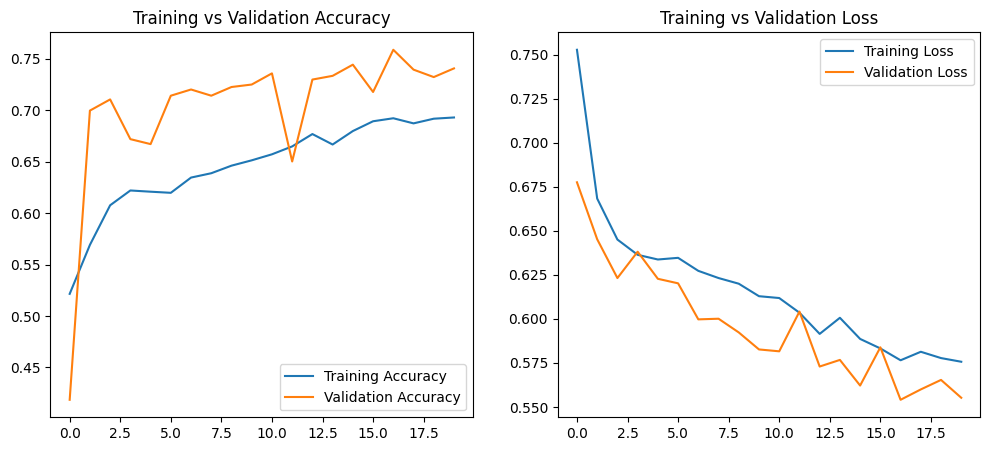

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()


In [13]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Akurasi Training Terakhir: {final_train_acc:.2%}")
print(f"Akurasi Validation Terakhir: {final_val_acc:.2%}")

Akurasi Training Terakhir: 69.29%
Akurasi Validation Terakhir: 74.07%


In [14]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 501ms/step - accuracy: 0.5854 - loss: 0.6161
Test Loss: 0.5891
Test Accuracy: 0.7016
